##Assessing the strain distribution of E. huxleyi compiled transcriptomes/genome transcripts in the field

In [2]:
#Read in important paths 
import pandas as pd
import cPickle as cpk
import matplotlib as mpl
import sys
import numpy as np
sys.path.append("/Users/harrietalexander/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.11-py2.7.egg")
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib import gridspec
from itertools import combinations
import palettable.colorbrewer as b2m
import palettable as pal
import glob
from Bio import SeqIO
from matplotlib.colors import LogNorm, NoNorm

# mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['pdf.fonttype']=42
%matplotlib inline

In [3]:
# #read in the named Transcriptome file with protein names --> gene families
# inFile=open("Ehux_All_Transcripts_Cleaned_RSEM.nt.fa.RSEM.tab", 'r')
# gFHash={}
# for i,c in enumerate(inFile):
# #     if i==10:
# #         break
#     if i%10000 == 0:
#         print i
#     c=c.split()
#     geneFamily=c[0].strip()
#     transcript=c[1].strip()
#     if geneFamily in gFHash.keys():
#         gFHash[geneFamily].append(transcript)
#     else:
#         gFHash[geneFamily]=[transcript]
# cpk.dump(gFHash, open('Ehux_Dictionary.pickle', 'w'))


In [4]:
#Use this first as the previous cell takes a really long time to run 
#Load a hash that is of the form gFHash[orthologGroup]=List of transcripts
gFHash=cpk.load(open('Ehux_Dictionary.pickle', 'r'))


In [5]:
#Parse the gFHash to tally the number of genes in an orthologus group and the number of genes from each of the individual taxa
#Panda dataframe of form : Orthologus group | total number of genes in orthologus group | total number from each strain
#Nested for loop... so it takes a while. 
Hist_PD=pd.DataFrame(index=gFHash.keys(),columns=['NumGenes', 'Emi374', 'Emi379', 'Emi370', 'Emi219', 'Emihu1'])
Hist_PD=Hist_PD.fillna(0)
for i,key in enumerate(gFHash):
#     if i==100:
#         break
    l=len(gFHash[key])
    Hist_PD.loc[key, 'NumGenes']=l
    for transcript in gFHash[key]:
        org=transcript.split('|')[0]
        Hist_PD.loc[key,org]+=1


####Number of genes per Orthologus Gene Clusters 
Create a histogram to plot the total number of gene clusters with each of the following umbers of transcripts per gene family. *Note: Dominated by the singleton genes (e.g. the genes that are "diagnostic of a species)*

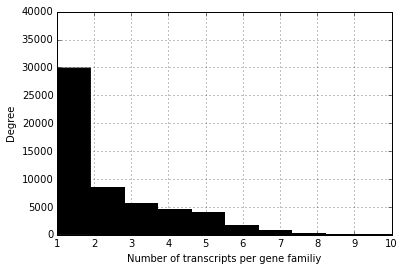

In [6]:

fig=Hist_PD.NumGenes.plot(kind='hist', range=[1,10],colormap=mpl.cm.gray)
fig.set_xlim(1,10)
fig.set_ylim(0,40000)
l=fig.set_xlabel("Number of transcripts per gene familiy")
fig.figure.savefig('Transcripts_per_OG.pdf')

In [7]:
#Random calculations that were part of thinking process. 
# orgs=['Emi374', 'Emi379', 'Emi370', 'Emi219', 'Emihu1']

# DiagnosticGenes={}
# DiagnosticGenes['Emi219']=Hist_PD[Hist_PD.Emi219==1].index
# DiagnosticGenes['Emi379']=Hist_PD[Hist_PD.Emi379==1].index
# DiagnosticGenes['Emi370']=Hist_PD[Hist_PD.Emi370==1].index
# DiagnosticGenes['Emi374']=Hist_PD[Hist_PD.Emi374==1].index
# DiagnosticGenes['Emihu1']=Hist_PD[Hist_PD.Emihu1==1].index

GenesInOrg={}
GenesInOrg['Emi219']=Hist_PD[Hist_PD.Emi219>0].index
GenesInOrg['Emi379']=Hist_PD[Hist_PD.Emi379>0].index
GenesInOrg['Emi370']=Hist_PD[Hist_PD.Emi370>0].index
GenesInOrg['Emi374']=Hist_PD[Hist_PD.Emi374>0].index
GenesInOrg['Emihu1']=Hist_PD[Hist_PD.Emihu1>0].index


####Create functions to: 
1. Identify all the genes (inclusively) that are in the subset of organisms
2. Identify the unique genes for subset of organism (e.g. only the genes that are unique to an organism)
3. Plot the data in an intuitive way (preferably something other than a venn diagram)

In [8]:

def Calculate_Venn_comparison(hash):
    #input = a Hash of the form hash[Organism]=list of orthologus groups
    #Outputs a hash of the form key = all the variations of thes sets : list of orthologus genes in an inclusive way
    #It is inclusive so the set containing A uniq genes is going to contain all the genes for an org
    variations={}
    for i in range(len(hash)):
        for v in combinations(hash.keys(), i+1):
            vsets = [hash[x] for x in v]
            variations[tuple(sorted(v))]=reduce(lambda x,y: x.intersection(y), vsets)
    return variations

def GetDifference_Venn(variations):
    #Function takes the input from the above function and outputs a hash of the same format but 
    #each set is uniqe: e.g. there are no repeats of orthologus groups across sets. 
    outdict={}
    vkeys=variations.keys()
    #loop over each of the variable cases
    for v in variations:
        #create a set to do the comparisons
        vset=set(v)
        vdata_set=set(variations[v])
        #loop over all other variations
        for j in variations:
            #if v is a subset of jset we want to remove the items of jset from v set
            jdata_set=set(variations[j])
            jset=set(j)
            if vset.issubset(jset):
                if vset==jset:
                    pass
                else: 
                    newdata=vdata_set-jdata_set
                    vdata_set=newdata
        outdict[v]=vdata_set
    return outdict

#Get the genes that are unique with in the venn: format of the hash = name of the subset : Orthologus gene groups
Genes_In_Each_Cat=Calculate_Venn_comparison(GenesInOrg)
Genes_Uniq_Venn=GetDifference_Venn(Genes_In_Each_Cat)


In [7]:
for key in Genes_Uniq_Venn:
    fName='_'.join(list(key))
    fName='Species_GeneLists_Venn/'+fName+'.list'
    file=open(fName, 'w')

    for item in Genes_Uniq_Venn[key]:
        file.write(item.strip())
        file.write('\n')
    file.close()

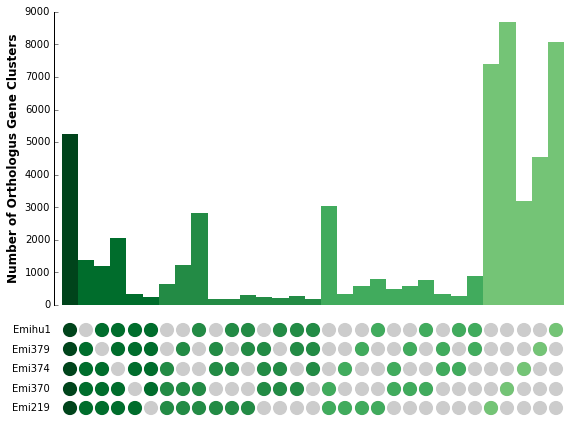

In [9]:

def plot_Scatter_histogram(Hash_in,s=200):
    #takes a hash of the form (set, numbers)
    #get the number of sets and the number of groups: get the lengths there in
    num_sets=len(Hash_in)
    grpNames=np.sort(list(set(np.hstack(Hash_in.keys()))))
    num_groups=len(grpNames)
    y=np.sort(num_sets*range(1,num_groups+1))
    x=num_groups*range(1,num_sets+1)

    color=b2m.sequential.Greys_5.hex_colors
    color_bar=b2m.sequential.Greens_9.hex_colors
#   fig=plt.figure(figsize=(num_sets/3, num_groups))
    fig = plt.figure(figsize=(8, 6)) 

    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    #create grid of dots
    ax2.scatter(x,y, c=color[1], linewidth=0, s=s)
    #alter the range etc. of pltos
    ax1.set_xlim([0, np.max(x)+.7])
    ax2.set_xlim([0, np.max(x)+.7])
    ax2.set_ylim([.5, np.max(y)+.5])
    ax2.set_yticks(range(1,num_groups+1))
    ax2.set_yticklabels(grpNames)
    ax2.spines['left'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.spines['bottom'].set_color('none')
    ax2.tick_params(axis='both',         
        which='both',      
        bottom='off',      
        top='off',  
        right='off',
        left='off',
        labelbottom='off') 
    ax1.tick_params(axis='both',         
        which='both',      
        bottom='off',      
        top='off',  
        right='off',
        labelbottom='off') 
#     ax1.spines['left'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.spines['bottom'].set_color('none')
    grpHash={}
    for i,x in enumerate(grpNames):
        grpHash[x]=i+1
    #sort he list of keys (sets) by the length of the set
    xs=Hash_in.keys()
    xs.sort()
    xs.sort(key = lambda s: len(s), reverse=True)
    plt.tight_layout()
    ax1.set_ylabel('Number of Orthologus Gene Clusters', fontsize='large', weight='bold')
    
    for i,key in enumerate(xs):
        nGenes=len(Hash_in[key])
        i+=1#number along the x axis
        for j in key:
            n=grpHash[j]#number along the y axis
            ax2.scatter(i,n, s=s, c=color_bar[len(key)+3], lw=0)
            rect=plt.Rectangle((i-.5,0), 1, nGenes, fc=color_bar[len(key)+3],lw=0)
            ax1.add_patch(rect)
            ax1.plot()
    return fig, xs
    
fig1,EHX_SortedList=plot_Scatter_histogram(Genes_Uniq_Venn,s=200)
fig1.savefig('Groups.pdf')

In [9]:
for k in Genes_Uniq_Venn:
    print k, len(Genes_Uniq_Venn[k])

('Emi219', 'Emi379', 'Emihu1') 296
('Emi219',) 7407
('Emi219', 'Emi379') 593
('Emi219', 'Emihu1') 783
('Emi219', 'Emi370', 'Emi374') 638
('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1') 5243
('Emi370',) 8686
('Emi219', 'Emi374', 'Emi379') 195
('Emi219', 'Emi370', 'Emihu1') 2815
('Emihu1',) 8085
('Emi374',) 3189
('Emi370', 'Emi379') 582
('Emi219', 'Emi374', 'Emihu1') 185
('Emi370', 'Emi374') 490
('Emi219', 'Emi370', 'Emi379', 'Emihu1') 2066
('Emi379',) 4536
('Emi370', 'Emi374', 'Emi379', 'Emihu1') 243
('Emi370', 'Emi379', 'Emihu1') 264
('Emi374', 'Emihu1') 280
('Emi219', 'Emi374', 'Emi379', 'Emihu1') 333
('Emi219', 'Emi374') 330
('Emi379', 'Emihu1') 874
('Emi374', 'Emi379', 'Emihu1') 172
('Emi370', 'Emi374', 'Emi379') 227
('Emi219', 'Emi370', 'Emi379') 1236
('Emi370', 'Emi374', 'Emihu1') 206
('Emi219', 'Emi370', 'Emi374', 'Emi379') 1380
('Emi219', 'Emi370') 3045
('Emi370', 'Emihu1') 751
('Emi219', 'Emi370', 'Emi374', 'Emihu1') 1196
('Emi374', 'Emi379') 321


####Import data from Isoforms and look at the "Core gene set" 
There are ~5000 core E. hux gense.  What do those genes look like from a distribution stand point? Are they equally represented across the taxa? 

In [10]:
CoreGenes=Genes_Uniq_Venn[('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1')] #get the genes that are core to all organisms
#create a PD Dataframe that is the number of genes from each org in the core gene set
TranscriptTally=pd.DataFrame(columns=('Emihu1','Emi219', 'Emi370', 'Emi374', 'Emi379'), index=CoreGenes) 
TranscriptTally=TranscriptTally.fillna(0)
for Gene in CoreGenes:
    for transcript in gFHash[Gene]:
        species=transcript.split('|')[0]
        TranscriptTally.loc[Gene,species]+=1


Emihu1    1.471486
Emi219    1.302880
Emi370    1.345985
Emi374    1.141522
Emi379    1.156971
dtype: float64


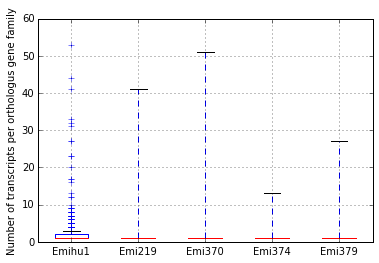

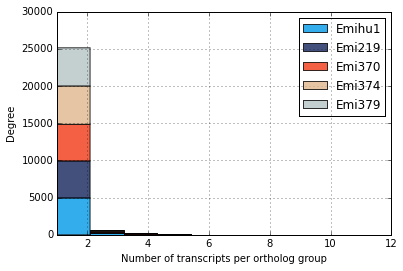

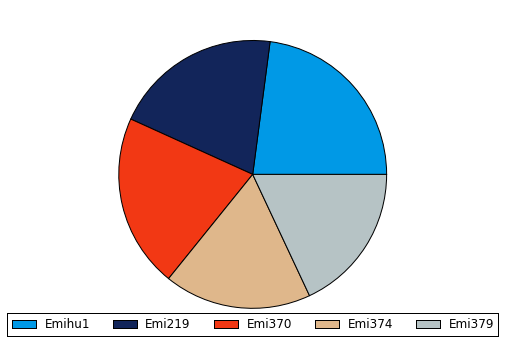

In [11]:

print TranscriptTally.mean()
cmap=pal.wesanderson.Zissou_5.mpl_colormap
cmap2=pal.wesanderson.Zissou_5.hex_colors

#Create a box plot with the mean number of genes in a set, etc. 
box=TranscriptTally.plot(kind='box')
box.set_ylim([0,60])
box.set_ylabel('Number of transcripts per orthologus gene family')
box.figure.savefig('BoxPlot_transcripts.pdf')
#Create a histogram showing the mean coverage per organism
hist=TranscriptTally.plot(kind='hist', stacked=True, range=[1,12],colormap=cmap, alpha=0.8)
hist.set_xlabel('Number of transcripts per ortholog group')
hist.set_xlim([1,12])
hist.figure.savefig('Histogram_transcriptsPerOrtholog.pdf')
#Make a pie chart o show the relative make up of the core gene set. 
percentofCore=TranscriptTally.sum()/TranscriptTally.sum().sum()
pie,ax=plt.subplots(1)
pie.set_size_inches(6,6)
ax.set_aspect('equal')
ax.pie(percentofCore, colors=cmap2)
leg=ax.legend(TranscriptTally.columns,loc=8, ncol=5)
pie.savefig('Piechart_CoreGenes.pdf')


###Now, onto the field data. Let's see how these distributions change as a fucntion of TPM in the field. 

In [12]:
#Import data

test=pd.read_table("../output_RSEM_Bowtie2/E2-R_ACTTGA.genes.results", index_col='gene_id')

outHash={}
for group in Genes_Uniq_Venn:
    p=test.loc[Genes_Uniq_Venn[group]].TPM.sum()
    outHash[group]=[len(Genes_Uniq_Venn[group]), p]

In [13]:
def plot_Scatter_histogram_fieldTPM(Hash_in,s=200, title=None, filetype='.pdf', plotType=None):
    #takes a hash of the form (set, numbers)
    #get the number of sets and the number of groups: get the lengths there in
    num_sets=len(Hash_in)
    grpNames=np.sort(list(set(np.hstack(Hash_in.keys()))))
    num_groups=len(grpNames)
    y=np.sort(num_sets*range(1,num_groups+1))
    x=num_groups*range(1,num_sets+1)

    color=b2m.sequential.Greys_5.hex_colors
    color_bar=b2m.sequential.Greens_9.hex_colors
#   fig=plt.figure(figsize=(num_sets/3, num_groups))
    fig = plt.figure(figsize=(8, 6)) 
    fig.suptitle(title)

    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    #create grid of dots
    ax2.scatter(x,y, c=color[1], linewidth=0, s=s)
    #alter the range etc. of pltos
    ax1.set_xlim([0, np.max(x)+.7])
    ax2.set_xlim([0, np.max(x)+.7])
    ax2.set_ylim([.5, np.max(y)+.5])
    ax2.set_yticks(range(1,num_groups+1))
    ax2.set_yticklabels(grpNames)
    ax2.spines['left'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.spines['bottom'].set_color('none')
    ax2.tick_params(axis='both',         
        which='both',      
        bottom='off',      
        top='off',  
        right='off',
        left='off',
        labelbottom='off') 
    ax1.tick_params(axis='both',         
        which='both',      
        bottom='off',      
        top='off',  
        right='off',
        labelbottom='off') 
#     ax1.spines['left'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.spines['bottom'].set_color('none')
    grpHash={}
    for i,x in enumerate(grpNames):
        grpHash[x]=i+1
    #sort he list of keys (sets) by the length of the set
    xs=Hash_in.keys()
    xs.sort()
    xs.sort(key = lambda s: len(s), reverse=True)
    plt.tight_layout()
    for i,key in enumerate(xs):
        nGenes=len(Hash_in[key])
        i+=1#number along the x axis
        for j in key:
            n=grpHash[j]#number along the y axis
            ax2.scatter(i,n, s=s, c=color_bar[len(key)+3], lw=0)
            if plotType=='tpm':
                rect=plt.Rectangle((i-.5,0), 1, Hash_in[key]['TPM'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('Total TPM', fontsize='large', weight='bold')

            elif plotType=='% of genes':
                rect=plt.Rectangle((i-.5,0), 1, float(Hash_in[key]['Greater0'])/Hash_in[key]['Len_total'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('% of genes expressed', fontsize='large', weight='bold')
            elif plotType=='TPM norm to % of genes in field':
                rect=plt.Rectangle((i-.5,0), 1, float(Hash_in[key]['TPM'])/Hash_in[key]['Greater0'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('TPM normalized to expressed genes #', fontsize='large', weight='bold')
             
            else:    
                rect=plt.Rectangle((i-.5,0), 1, Hash_in[key]['TPM']/Hash_in[key]['Len_total'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('Average TPM within Group', fontsize='large', weight='bold')

            ax1.add_patch(rect)
            ax1.plot()
    fig.savefig(title+filetype)
    return fig

def ParseField_RSEM_Files(files):
    InsituHash={}
    for f in glob.glob(files):
        name=f.split('/')[2]
        name=name.split('_')[0]
        print name
        InsituHash[name]=pd.read_table(f,index_col='gene_id')

    outHash={}
    for sample in InsituHash:
        a={}
        for group in Genes_Uniq_Venn:
            match=InsituHash[sample].loc[Genes_Uniq_Venn[group]].TPM
            summedTPM=InsituHash[sample].loc[Genes_Uniq_Venn[group]].TPM.sum()
            len_match=len(match)
            len_match_greater0=len(match[match>0])
            a[group]={}
            a[group]['TPM']=summedTPM
            a[group]['Len_total']=len_match
            a[group]['Greater0']=len_match_greater0
        outHash[sample]=a
    return outHash
        


##Field

Trying to decide which of the above figures is best for paper purposes... make a script to make a matrix of graphs

First, look at the overall mapping relative to total

In [10]:
import re
d=[]
for f in glob.glob('../output_RSEM_Bowtie2/*cnt'):
    handle=open(f)
    m = re.search('/E.*?_',f)
    name=m.group(0)[1:-1]
    for i, line in enumerate(handle):
        if i ==0:
            mapped=float(line.split(' ')[1])
            total=float(line.split(' ')[3].strip())
    d.append({'Name':name, 'mapped':mapped, 'total':total})
Mappedreads=pd.DataFrame(d)        
Mappedreads=Mappedreads.set_index('Name')

Mappedreads['percentMapped']=Mappedreads.mapped/Mappedreads.total

Mappedreads

,mapped,total,percentMapped
Name,,,
E1-Q,462171,59062921,0.007825
E1-R,1057495,65795543,0.016072
E1-S,419328,62741183,0.006683
E1-T,302961,64300869,0.004712
E1-V,558014,61313645,0.009101
E1-X,814502,68238646,0.011936
E1-Z1,273787,60929881,0.004493
E1-Z4,295641,63451975,0.004659
E2-Q,249563,62776333,0.003975


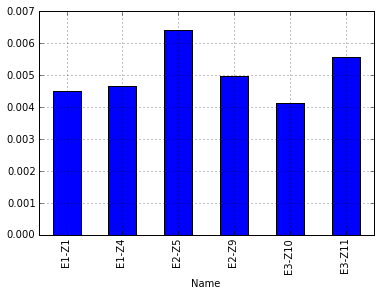

In [497]:
insitu=['E1-Z1','E1-Z4','E2-Z5','E2-Z9','E3-Z10','E3-Z11']
Mappedreads.loc[insitu].percentMapped.plot(kind = 'bar')

###First order observations: 

1. It is nitrogen addition that is driving the DSW response
2. Step-wise pattern falls along what we would expect. 
3. We get better coverage ~100% of the core genes
4. Pan genome in effect; hundreds of organisms.  The signals are not strong; but they are there. 
5. We have many strains out there; the dominant strain is closely related to the genome strain.
6. When you perturb the conditions it is selecting for a genome that is not present in our analytical window. 
7. Scaling of genes: w/R if we se ea scaling; we can't look at the unique stuff-- but we can look at the core set. 


Get a QMF done
Get a relative proportion of genes (kegg breakdown etc). 


In [14]:
def plot_Scatter_histogram_fieldTPM_grid(Hash_in,s=200, title=None, filetype='.pdf', plotType=None, ax1=None):
    #takes a hash of the form (set, numbers)
    #get the number of sets and the number of groups: get the lengths there in
    num_sets=len(Hash_in)
    grpNames=np.sort(list(set(np.hstack(Hash_in.keys()))))
    num_groups=len(grpNames)
    y=np.sort(num_sets*range(1,num_groups+1))
    x=num_groups*range(1,num_sets+1)

    color=b2m.sequential.Greys_5.hex_colors
    color_bar=b2m.sequential.Greens_9.hex_colors
#   fig=plt.figure(figsize=(num_sets/3, num_groups))
    if ax1==None:
        
        fig = plt.figure(figsize=(8, 6)) 
#     fig.suptitle(title)
        ax1=fig.add_subplot(111)
#     gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
#     ax1 = plt.subplot(gs[0])
#     ax2 = plt.subplot(gs[1])
    #create grid of dots
#     ax2.scatter(x,y, c=color[1], linewidth=0, s=s)
    #alter the range etc. of pltos
    ax1.set_xlim([0, np.max(x)+.7])
#     ax2.set_xlim([0, np.max(x)+.7])
#     ax2.set_ylim([.5, np.max(y)+.5])
#     ax2.set_yticks(range(1,num_groups+1))
#     ax2.set_yticklabels(grpNames)
#     ax2.spines['left'].set_color('none')
#     ax2.spines['right'].set_color('none')
#     ax2.spines['top'].set_color('none')
#     ax2.spines['bottom'].set_color('none')
#     ax2.tick_params(axis='both',         
#         which='both',      
#         bottom='off',      
#         top='off',  
#         right='off',
#         left='off',
#         labelbottom='off') 
    ax1.set_title(title)
    ax1.tick_params(axis='both',         
        which='both',      
        bottom='off',      
        top='off',  
        right='off',
        labelbottom='off') 
#     ax1.spines['left'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.spines['bottom'].set_color('none')
    grpHash={}
    for i,x in enumerate(grpNames):
        grpHash[x]=i+1
    #sort he list of keys (sets) by the length of the set
    xs=Hash_in.keys()
    xs.sort()
    xs.sort(key = lambda s: len(s), reverse=True)
    plt.tight_layout()
    for i,key in enumerate(xs):
        nGenes=len(Hash_in[key])
        i+=1#number along the x axis
        for j in key:
            n=grpHash[j]#number along the y axis
#             ax2.scatter(i,n, s=s, c=color_bar[len(key)+3], lw=0)
            if plotType=='tpm':
                rect=plt.Rectangle((i-.5,0), 1, Hash_in[key]['TPM'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('Total TPM', fontsize='large', weight='bold')

            elif plotType=='% of genes':
                rect=plt.Rectangle((i-.5,0), 1, float(Hash_in[key]['Greater0'])/Hash_in[key]['Len_total'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('% of genes expressed', fontsize='large', weight='bold')
            elif plotType=='TPM norm to % of genes in field':
                rect=plt.Rectangle((i-.5,0), 1, float(Hash_in[key]['TPM'])/Hash_in[key]['Greater0'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('TPM normalized to expressed genes #', fontsize='large', weight='bold')
             
            else:    
                rect=plt.Rectangle((i-.5,0), 1, Hash_in[key]['TPM']/Hash_in[key]['Len_total'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('Average TPM within Group', fontsize='large', weight='bold')

            ax1.add_patch(rect)
            ax1.plot()
    return ax1

def plot_Scatter_grid(Hash_in,s=200, title=None, ax2=None):
    #given an axis plot the scatter of species 
    #takes a hash of the form (set, numbers)
    #get the number of sets and the number of groups: get the lengths there in
    num_sets=len(Hash_in)
    grpNames=np.sort(list(set(np.hstack(Hash_in.keys()))))
    num_groups=len(grpNames)
    y=np.sort(num_sets*range(1,num_groups+1))
    x=num_groups*range(1,num_sets+1)
    color=b2m.sequential.Greys_5.hex_colors
    color_bar=b2m.sequential.Greens_9.hex_colors
    if ax2==None:
        fig = plt.figure(figsize=(8, 6)) 
        ax2=fig.add_subplot(111)
    ax2.scatter(x,y, c=color[1], linewidth=0, s=s)

    ax2.set_xlim([0, np.max(x)+.7])
    ax2.set_ylim([.5, np.max(y)+.5])
    ax2.set_yticks(range(1,num_groups+1))
    ax2.set_yticklabels(grpNames)
    ax2.spines['left'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.spines['bottom'].set_color('none')
    ax2.tick_params(axis='both',         
        which='both',      
        bottom='off',      
        top='off',  
        right='off',
        left='off',
        labelbottom='off') 
    grpHash={}
    for i,x in enumerate(grpNames):
        grpHash[x]=i+1
    #sort he list of keys (sets) by the length of the set
    xs=Hash_in.keys()
    xs.sort()
    xs.sort(key = lambda s: len(s), reverse=True)
    plt.tight_layout()
    for i,key in enumerate(xs):
        nGenes=len(Hash_in[key])
        i+=1#number along the x axis
        for j in key:
            n=grpHash[j]#number along the y axis
            ax2.scatter(i,n, s=s, c=color_bar[len(key)+3], lw=0)

def ParseField_RSEM_Files(files):
    InsituHash={}
    for f in glob.glob(files):
        name=f.split('/')[2]
        name=name.split('_')[0]
        print name
        InsituHash[name]=pd.read_table(f,index_col='gene_id')

    outHash={}
    for sample in InsituHash:
        a={}
        for group in Genes_Uniq_Venn:
            match=InsituHash[sample].loc[Genes_Uniq_Venn[group]].TPM
            summedTPM=InsituHash[sample].loc[Genes_Uniq_Venn[group]].TPM.sum()
            len_match=len(match)
            len_match_greater0=len(match[match>0])
            a[group]={}
            a[group]['TPM']=summedTPM
            a[group]['Len_total']=len_match
            a[group]['Greater0']=len_match_greater0
        outHash[sample]=a
    return outHash
        

    
    


In [90]:
InsituHash=ParseField_RSEM_Files('../output_RSEM_Bowtie2/*Z*genes.results')


E1-Z1
E1-Z4
E2-Z5
E2-Z9
E3-Z10
E3-Z11


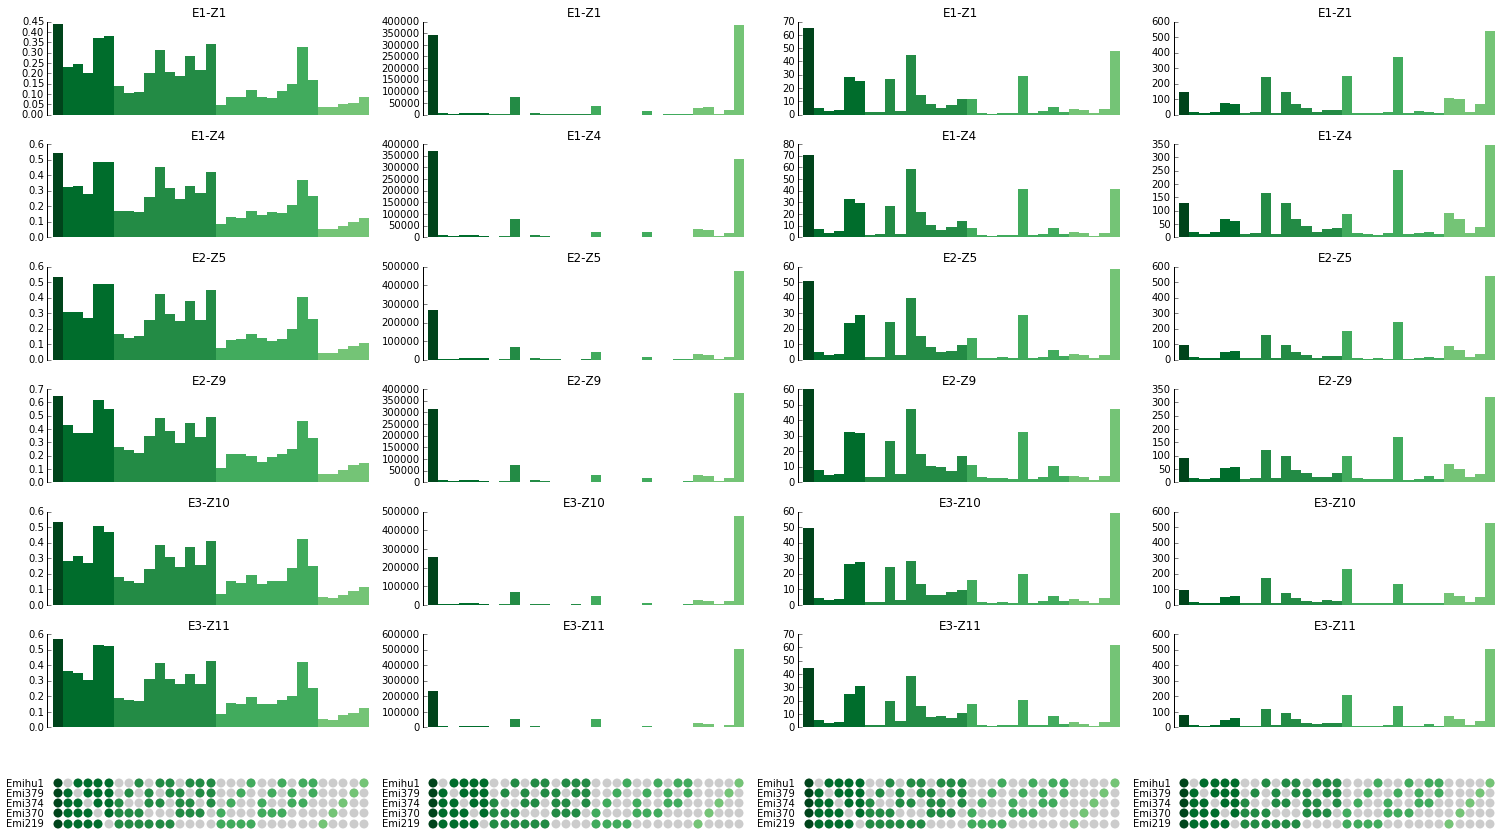

In [19]:
fig,axs=plt.subplots(7,4)
fig.set_size_inches(21,12)
sortedKeys=sorted(InsituHash.keys())

for i,ax in zip(sortedKeys,axs[0:6,0]):
    plot_Scatter_histogram_fieldTPM_grid(InsituHash[i], title=i, plotType='% of genes',ax1=ax)
    ax.set_ylabel('')

for i,ax in zip(sortedKeys,axs[:,1]):
    plot_Scatter_histogram_fieldTPM_grid(InsituHash[i], title=i, plotType='tpm',ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[:,2]):
    plot_Scatter_histogram_fieldTPM_grid(InsituHash[i], title=i, ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[:,3]):
    plot_Scatter_histogram_fieldTPM_grid(InsituHash[i], title=i, plotType='TPM norm to % of genes in field',ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(InsituHash,axs[6]):
    plot_Scatter_grid(InsituHash[i], s=80, ax2=ax)
    ax.set_aspect('equal')
    ax.set_ylabel('')
fig.savefig('Insitu_composite.pdf')

In [20]:
E1_Field=ParseField_RSEM_Files('../output_RSEM_Bowtie2/E1-[QRSTVX]*genes.results')


E1-Q
E1-R
E1-S
E1-T
E1-V
E1-X


["('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1')", "('Emi219', 'Emi370', 'Emi374', 'Emi379')", "('Emi219', 'Emi370', 'Emi374', 'Emihu1')", "('Emi219', 'Emi370', 'Emi379', 'Emihu1')", "('Emi219', 'Emi374', 'Emi379', 'Emihu1')", "('Emi370', 'Emi374', 'Emi379', 'Emihu1')", "('Emi219', 'Emi370', 'Emi374')", "('Emi219', 'Emi370', 'Emi379')", "('Emi219', 'Emi370', 'Emihu1')", "('Emi219', 'Emi374', 'Emi379')", "('Emi219', 'Emi374', 'Emihu1')", "('Emi219', 'Emi379', 'Emihu1')", "('Emi370', 'Emi374', 'Emi379')", "('Emi370', 'Emi374', 'Emihu1')", "('Emi370', 'Emi379', 'Emihu1')", "('Emi374', 'Emi379', 'Emihu1')", "('Emi219', 'Emi370')", "('Emi219', 'Emi374')", "('Emi219', 'Emi379')", "('Emi219', 'Emihu1')", "('Emi370', 'Emi374')", "('Emi370', 'Emi379')", "('Emi370', 'Emihu1')", "('Emi374', 'Emi379')", "('Emi374', 'Emihu1')", "('Emi379', 'Emihu1')", "('Emi219',)", "('Emi370',)", "('Emi374',)", "('Emi379',)", "('Emihu1',)"]


KeyError: '('

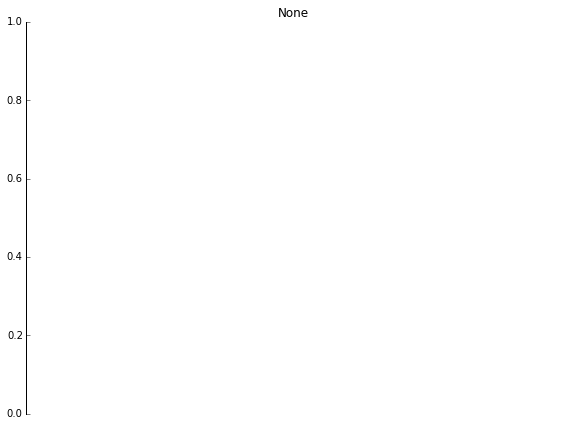

In [115]:
def plot_Scatter_histogram_fieldTPM_grid(Hash_in,s=200, title=None, filetype='.pdf', plotType=None, ax1=None):
    #takes a hash of the form (set, numbers)
    #get the number of sets and the number of groups: get the lengths there in
    num_sets=len(Hash_in)
    grpNames=np.sort(list(set(np.hstack(Hash_in.keys()))))
    num_groups=len(grpNames)
    y=np.sort(num_sets*range(1,num_groups+1))
    x=num_groups*range(1,num_sets+1)

    color=b2m.sequential.Greys_5.hex_colors
    color_bar=b2m.sequential.Greens_9.hex_colors
#   fig=plt.figure(figsize=(num_sets/3, num_groups))
    if ax1==None:
        
        fig = plt.figure(figsize=(8, 6)) 
#     fig.suptitle(title)
        ax1=fig.add_subplot(111)
#     gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
#     ax1 = plt.subplot(gs[0])
#     ax2 = plt.subplot(gs[1])
    #create grid of dots
#     ax2.scatter(x,y, c=color[1], linewidth=0, s=s)
    #alter the range etc. of pltos
    ax1.set_xlim([0, np.max(x)+.7])
    ax1.set_title(title)
    ax1.tick_params(axis='both',         
        which='both',      
        bottom='off',      
        top='off',  
        right='off',
        labelbottom='off') 
#     ax1.spines['left'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.spines['bottom'].set_color('none')
    grpHash={}
    for i,x in enumerate(grpNames):
        grpHash[x]=i+1
    #sort he list of keys (sets) by the length of the set
    xs=Hash_in.keys()
    xs.sort()
    xs.sort(key = lambda s: len(s), reverse=True)
    print xs
    plt.tight_layout()
    for i,key in enumerate(xs):
        nGenes=len(Hash_in[key])
        i+=1#number along the x axis
        for j in key:
            n=grpHash[j]#number along the y axis
#             ax2.scatter(i,n, s=s, c=color_bar[len(key)+3], lw=0)
            if plotType=='tpm':
                rect=plt.Rectangle((i-.5,0), 1, Hash_in[key]['TPM'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('Total TPM', fontsize='large', weight='bold')

            elif plotType=='% of genes':
                rect=plt.Rectangle((i-.5,0), 1, float(Hash_in[key]['Greater0'])/Hash_in[key]['Len_total'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('% of genes expressed', fontsize='large', weight='bold')
            elif plotType=='TPM norm to % of genes in field':
                rect=plt.Rectangle((i-.5,0), 1, float(Hash_in[key]['TPM'])/Hash_in[key]['Greater0'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('TPM normalized to expressed genes #', fontsize='large', weight='bold')
             
            else:    
                rect=plt.Rectangle((i-.5,0), 1, Hash_in[key]['TPM']/Hash_in[key]['Len_total'], fc=color_bar[len(key)+3],lw=0)
                ax1.set_ylabel('Average TPM within Group', fontsize='large', weight='bold')

            ax1.add_patch(rect)
            ax1.plot()
    return ax1
plot_Scatter_histogram_fieldTPM_grid(InsituHash['E1-Z1'],s=200, title=None, filetype='.pdf', plotType=None, ax1=None)


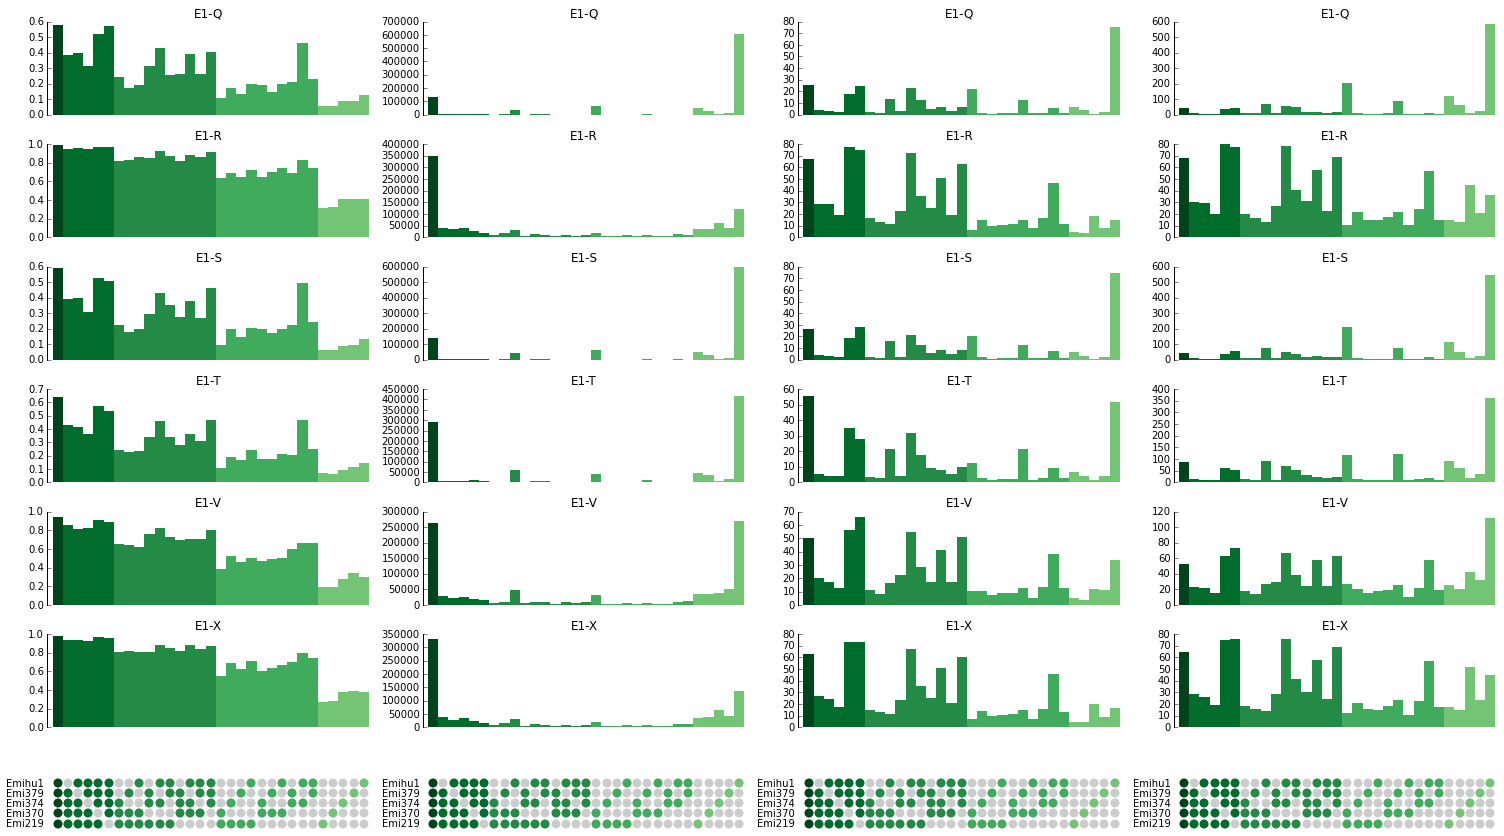

In [21]:
fig,axs=plt.subplots(7,4)
fig.set_size_inches(21,12)
sortedKeys=sorted(E1_Field.keys())

for i,ax in zip(sortedKeys,axs[0:6,0]):
    plot_Scatter_histogram_fieldTPM_grid(E1_Field[i], title=i, plotType='% of genes',ax1=ax)
    ax.set_ylabel('')

for i,ax in zip(sortedKeys,axs[:,1]):
    plot_Scatter_histogram_fieldTPM_grid(E1_Field[i], title=i, plotType='tpm',ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[:,2]):
    plot_Scatter_histogram_fieldTPM_grid(E1_Field[i], title=i, ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[:,3]):
    plot_Scatter_histogram_fieldTPM_grid(E1_Field[i], title=i, plotType='TPM norm to % of genes in field',ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[6]):
    plot_Scatter_grid(E1_Field[i], s=80, ax2=ax)
    ax.set_aspect('equal')
    ax.set_ylabel('')
    
fig.savefig('E1_composite.pdf')

In [50]:
E2_Field=ParseField_RSEM_Files('../output_RSEM_Bowtie2/E2-[QRSTVX]*genes.results')


E2-Q
E2-R
E2-S
E2-T
E2-V
E2-X


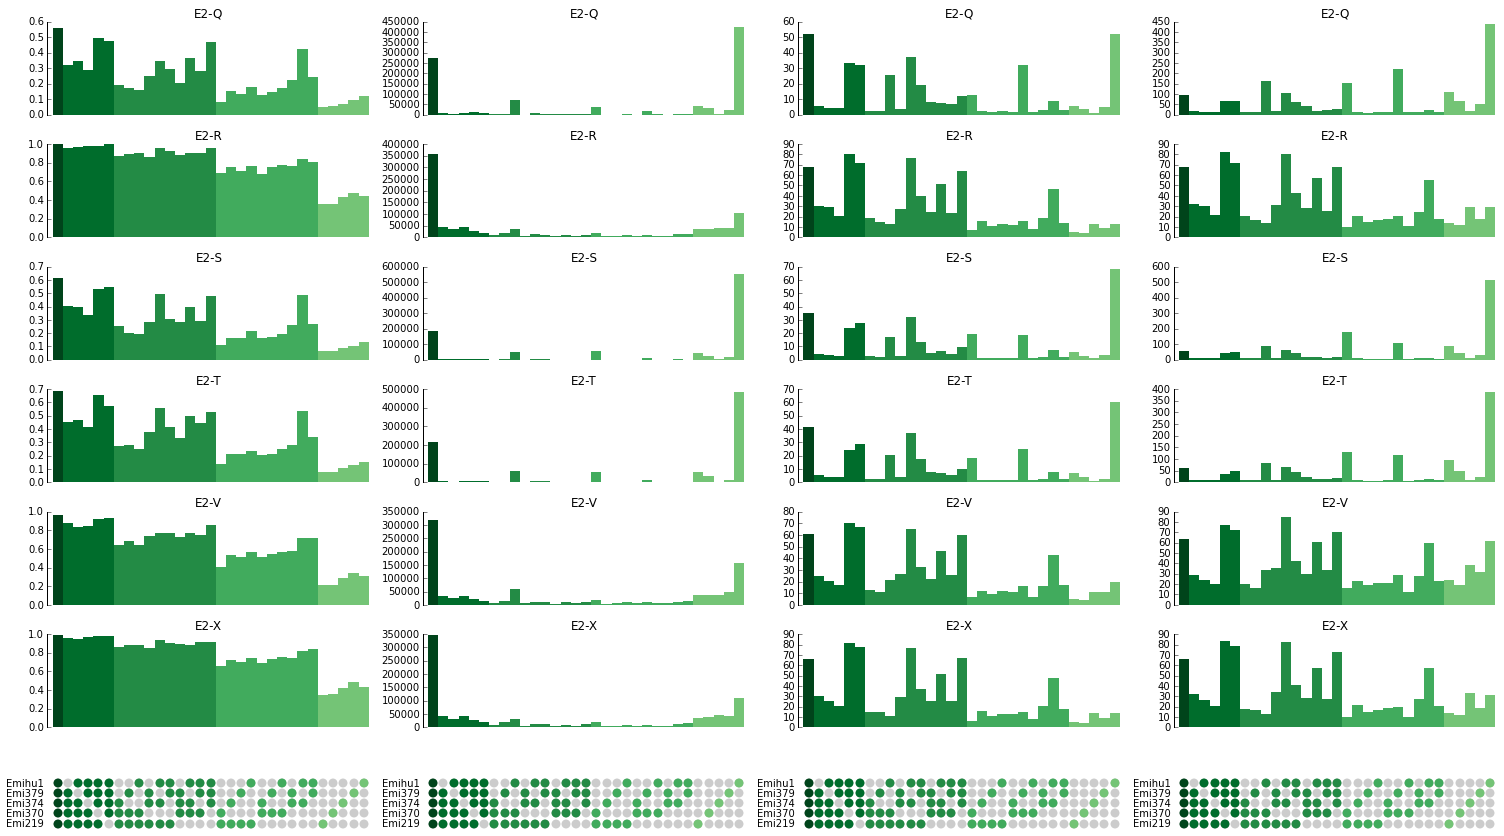

In [72]:
fig,axs=plt.subplots(7,4)
fig.set_size_inches(21,12)
sortedKeys=sorted(E2_Field.keys())

for i,ax in zip(sortedKeys,axs[0:6,0]):
    plot_Scatter_histogram_fieldTPM_grid(E2_Field[i], title=i, plotType='% of genes',ax1=ax)
    ax.set_ylabel('')

for i,ax in zip(sortedKeys,axs[:,1]):
    plot_Scatter_histogram_fieldTPM_grid(E2_Field[i], title=i, plotType='tpm',ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[:,2]):
    plot_Scatter_histogram_fieldTPM_grid(E2_Field[i], title=i, ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[:,3]):
    plot_Scatter_histogram_fieldTPM_grid(E2_Field[i], title=i, plotType='TPM norm to % of genes in field',ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[6]):
    plot_Scatter_grid(E2_Field[i], s=80, ax2=ax)
    ax.set_aspect('equal')
    ax.set_ylabel('')
    
fig.savefig('E2_composite.pdf')

In [59]:
E3_Field=ParseField_RSEM_Files('../output_RSEM_Bowtie2/E3-[QRSTVX]*genes.results')


E3-Q
E3-R
E3-S
E3-T
E3-V
E3-X


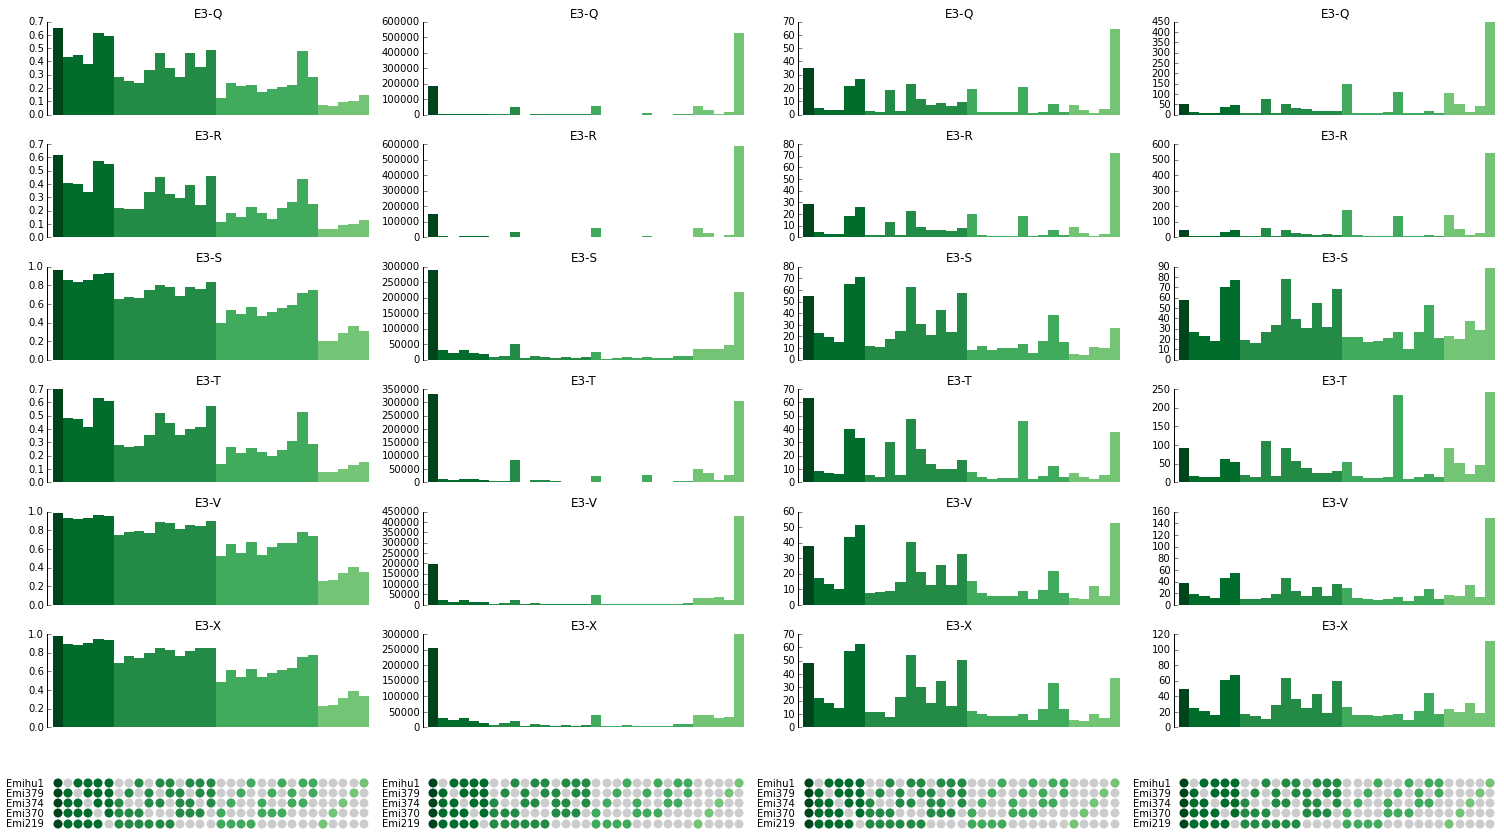

In [73]:
fig,axs=plt.subplots(7,4)
fig.set_size_inches(21,12)
sortedKeys=sorted(E3_Field.keys())

for i,ax in zip(sortedKeys,axs[0:6,0]):
    plot_Scatter_histogram_fieldTPM_grid(E3_Field[i], title=i, plotType='% of genes',ax1=ax)
    ax.set_ylabel('')

for i,ax in zip(sortedKeys,axs[:,1]):
    plot_Scatter_histogram_fieldTPM_grid(E3_Field[i], title=i, plotType='tpm',ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[:,2]):
    plot_Scatter_histogram_fieldTPM_grid(E3_Field[i], title=i, ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[:,3]):
    plot_Scatter_histogram_fieldTPM_grid(E3_Field[i], title=i, plotType='TPM norm to % of genes in field',ax1=ax)
    ax.set_ylabel('')
    
for i,ax in zip(sortedKeys,axs[6]):
    plot_Scatter_grid(E3_Field[i], s=80, ax2=ax)
    ax.set_aspect('equal')
    ax.set_ylabel('')
fig.savefig('E3_composite.pdf')

In [74]:
def ParseField_RSEM_Files_Isoforms(files):
    InsituHash={}
    for f in glob.glob(files):
        name=f.split('/')[2]
        name=name.split('_')[0]
        print name
        InsituHash[name]=pd.read_table(f,index_col='gene_id')
        sList=[]
        for transcript in InsituHash[name].transcript_id:
            species=transcript.split('|')
            sList.append(species[0])
        InsituHash[name]['species']=sList
    return InsituHash
        



E1-Z1
E1-Z4
E2-Z5
E2-Z9
E3-Z10
E3-Z11


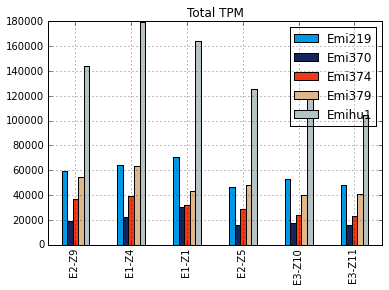

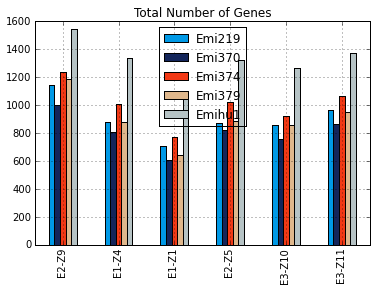

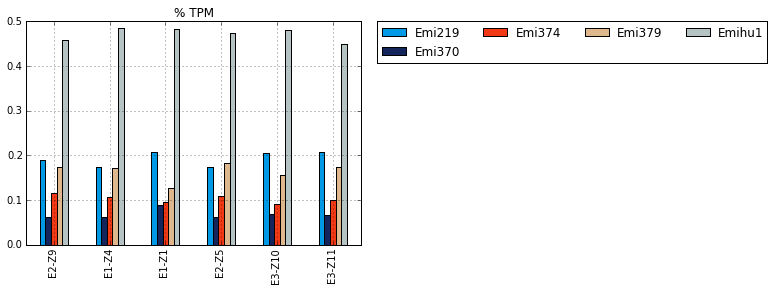

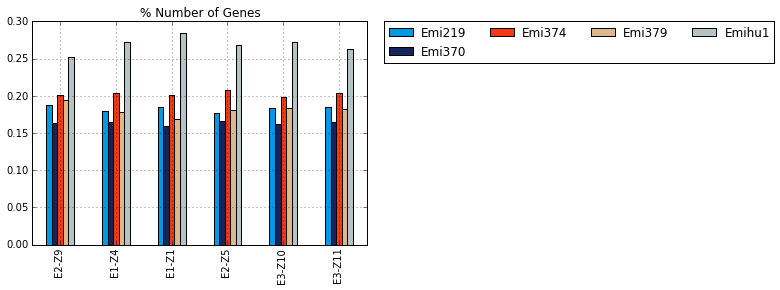

In [83]:
Iso=ParseField_RSEM_Files_Isoforms('../output_RSEM_Bowtie2/*Z*isoforms*')

Iso_TPM=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_TPM=Iso_TPM.fillna(0)
Iso_Ct=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_Ct=Iso_Ct.fillna(0)
Iso_TPM_percent=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_Ct_percent=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())

for sample in Iso:
    trans=Iso[sample].loc[CoreGenes]
    totalSum=trans.TPM.sum()
    totalNumber=0
    for E in ['Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1']:
        s_trans=trans[trans.species==E].TPM
        tsum=s_trans.sum()
        tnum=len(s_trans[s_trans>0])
        Iso_TPM.loc[sample, E]=tsum
        Iso_Ct.loc[sample, E]=tnum
        totalNumber+=tnum
    Iso_TPM_percent.loc[sample]=Iso_TPM.loc[sample]/Iso_TPM.loc[sample].sum()
    Iso_Ct_percent.loc[sample]=Iso_Ct.loc[sample]/Iso_Ct.loc[sample].sum()

#     Iso_TPM.loc[sample, 'total']=totalSum
#     Iso_Ct.loc[sample, 'total']=totalNumber
Iso_TPM.plot(kind='bar', colormap=cmap, title='Total TPM')
Iso_Ct.plot(kind='bar', colormap=cmap, title='Total Number of Genes')
ips=Iso_TPM_percent.plot(kind='bar', colormap=cmap, title='% TPM')
ics=Iso_Ct_percent.plot(kind='bar', colormap=cmap, title='% Number of Genes')
ips.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)
ics.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

ips.figure.savefig('Percent_Iso.pdf')
ics.figure.savefig('Percent_Number_Genes.pdf')


E1-Q
E1-R
E1-S
E1-T
E1-V
E1-X


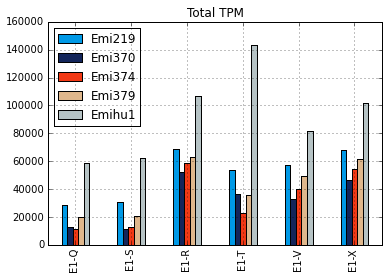

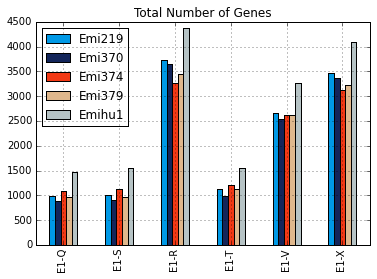

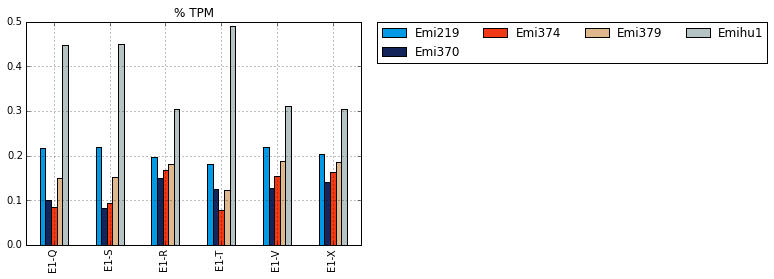

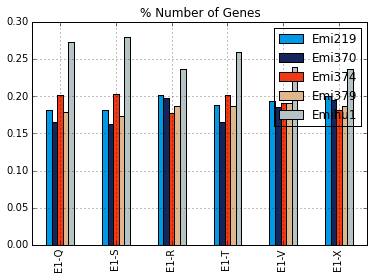

In [81]:
Iso=ParseField_RSEM_Files_Isoforms('../output_RSEM_Bowtie2/E1-[QRSTVX]*isoforms*')

Iso_TPM=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_TPM=Iso_TPM.fillna(0)
Iso_Ct=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_Ct=Iso_Ct.fillna(0)
Iso_TPM_percent=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_Ct_percent=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())

for sample in Iso:
    trans=Iso[sample].loc[CoreGenes]
    totalSum=trans.TPM.sum()
    totalNumber=0
    for E in ['Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1']:
        s_trans=trans[trans.species==E].TPM
        tsum=s_trans.sum()
        tnum=len(s_trans[s_trans>0])
        Iso_TPM.loc[sample, E]=tsum
        Iso_Ct.loc[sample, E]=tnum
        totalNumber+=tnum
    Iso_TPM_percent.loc[sample]=Iso_TPM.loc[sample]/Iso_TPM.loc[sample].sum()
    Iso_Ct_percent.loc[sample]=Iso_Ct.loc[sample]/Iso_Ct.loc[sample].sum()

#     Iso_TPM.loc[sample, 'total']=totalSum
#     Iso_Ct.loc[sample, 'total']=totalNumber
Iso_TPM.plot(kind='bar', colormap=cmap, title='Total TPM')
Iso_Ct.plot(kind='bar', colormap=cmap, title='Total Number of Genes')
itps=Iso_TPM_percent.plot(kind='bar', colormap=cmap, title='% TPM')
Iso_Ct_percent.plot(kind='bar', colormap=cmap, title='% Number of Genes')

itps.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

itps.figure.savefig('PercentTPM_E1.pdf') 

E2-Q
E2-R
E2-S
E2-T
E2-V
E2-X


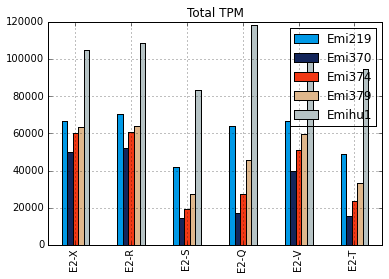

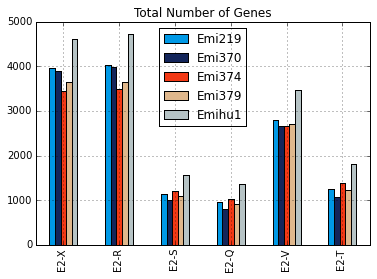

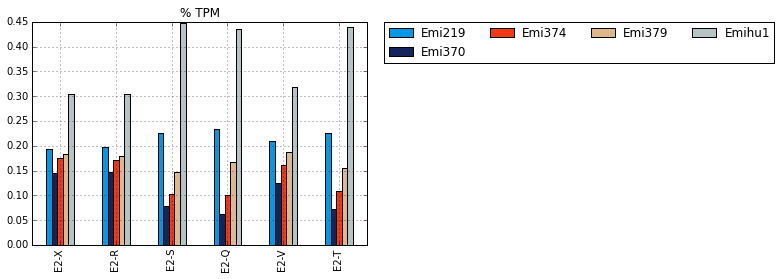

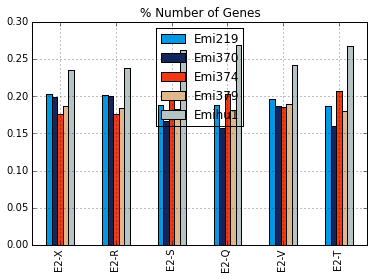

In [82]:
Iso=ParseField_RSEM_Files_Isoforms('../output_RSEM_Bowtie2/E2-[QRSTVX]*isoforms*')

Iso_TPM=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_TPM=Iso_TPM.fillna(0)
Iso_Ct=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_Ct=Iso_Ct.fillna(0)
Iso_TPM_percent=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())
Iso_Ct_percent=pd.DataFrame(columns=('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1'), index=Iso.keys())

for sample in Iso:
    trans=Iso[sample].loc[CoreGenes]
    totalSum=trans.TPM.sum()
    totalNumber=0
    for E in ['Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1']:
        s_trans=trans[trans.species==E].TPM
        tsum=s_trans.sum()
        tnum=len(s_trans[s_trans>0])
        Iso_TPM.loc[sample, E]=tsum
        Iso_Ct.loc[sample, E]=tnum
        totalNumber+=tnum
    Iso_TPM_percent.loc[sample]=Iso_TPM.loc[sample]/Iso_TPM.loc[sample].sum()
    Iso_Ct_percent.loc[sample]=Iso_Ct.loc[sample]/Iso_Ct.loc[sample].sum()

#     Iso_TPM.loc[sample, 'total']=totalSum
#     Iso_Ct.loc[sample, 'total']=totalNumber
Iso_TPM.plot(kind='bar', colormap=cmap, title='Total TPM', )
Iso_Ct.plot(kind='bar', colormap=cmap, title='Total Number of Genes')
itps=Iso_TPM_percent.plot(kind='bar', colormap=cmap, title='% TPM')
Iso_Ct_percent.plot(kind='bar', colormap=cmap, title='% Number of Genes')

itps.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

itps.figure.savefig('PercentTPM_E2.pdf') 

In [938]:
AllCoreGenes=set()
for gene in CoreGenes:
    for g in gFHash[gene]: 
        AllCoreGenes.update([g])
        
inFasta='Ehux_All_Transcripts_Cleaned_RSEM.nt.fa'
outFasta=open(inFasta+'.CEGMA.CoreGenes', 'w')
outList=[]
for record in SeqIO.parse(inFasta, 'fasta'):
    if record.id in AllCoreGenes:
        outList.append(record)

SeqIO.write(outList, outFasta, 'fasta')

33654

In [1]:
"""
Example of creating a radar chart (a.k.a. a spider or star chart) [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = 2*np.pi * np.linspace(0, 1-1./num_vars, num_vars)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180/np.pi, labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


def example_data():
    #The following data is from the Denver Aerosol Sources and Health study.
    #See  doi:10.1016/j.atmosenv.2008.12.017
    #
    #The data are pollution source profile estimates for five modeled pollution
    #sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical species.
    #The radar charts are experimented with here to see if we can nicely
    #visualize how the modeled source profiles change across four scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase speciesis present...
    data = {
        'column names':
            ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO',
             'O3'],
        'Basecase':
            [[0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
             [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
             [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
             [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
             [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]],
        'With CO':
            [[0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
             [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
             [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
             [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
             [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]],
        'With O3':
            [[0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
             [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
             [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
             [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
             [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]],
        'CO & O3':
            [[0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
             [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
             [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
             [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
             [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]]}
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop('column names')

    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for n, title in enumerate(data.keys()):
        ax = fig.add_subplot(2, 2, n+1, projection='radar')
        plt.rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(data[title], colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    plt.subplot(2, 2, 1)
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = plt.legend(labels, loc=(0.9, .95), labelspacing=0.1)
    plt.setp(legend.get_texts(), fontsize='small')

    plt.figtext(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
                ha='center', color='black', weight='bold', size='large')
    plt.show()

In [27]:
def plot_Scatter_grid(Hash_in,s=200, title=None, ax2=None):
    #given an axis plot the scatter of species 
    #takes a hash of the form (set, numbers)
    #get the number of sets and the number of groups: get the lengths there in
    num_sets=len(Hash_in)
    grpNames=np.sort(list(set(np.hstack(Hash_in.keys()))))
    num_groups=len(grpNames)
    y=np.sort(num_sets*range(1,num_groups+1))
    x=num_groups*range(1,num_sets+1)
    color=b2m.sequential.Greys_5.hex_colors
    color_bar=b2m.sequential.Greens_9.hex_colors
    if ax2==None:
        fig = plt.figure(figsize=(8, 6)) 
        ax2=fig.add_subplot(111)
    ax2.scatter(x,y, c=color[1], linewidth=0, s=s)

    ax2.set_xlim([0, np.max(x)+.7])
    ax2.set_ylim([.5, np.max(y)+.5])
    ax2.set_yticks(range(1,num_groups+1))
    ax2.set_yticklabels(grpNames)
    ax2.spines['left'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.spines['bottom'].set_color('none')
    ax2.tick_params(axis='both',         
        which='both',      
        bottom='off',      
        top='off',  
        right='off',
        left='off',
        labelbottom='off') 
    grpHash={}
    for i,x in enumerate(grpNames):
        grpHash[x]=i+1
    #sort he list of keys (sets) by the length of the set
    xs=Hash_in.keys()
    xs.sort()
    xs.sort(key = lambda s: len(s), reverse=True)
    plt.tight_layout()
    for i,key in enumerate(xs):
        nGenes=len(Hash_in[key])
        i+=1#number along the x axis
        for j in key:
            n=grpHash[j]#number along the y axis
            ax2.scatter(i,n, s=s, c=color_bar[len(key)+3], lw=0)



E2-Z9
E1-Z4
E1-Z1
E2-Z5
E3-Z10
E3-Z11


In [256]:
InsituHash=ParseField_RSEM_Files('../output_RSEM_Bowtie2/*Z*genes.results')
E3_Field=ParseField_RSEM_Files('../output_RSEM_Bowtie2/E3-[QRSTVX]*genes.results')
E2_Field=ParseField_RSEM_Files('../output_RSEM_Bowtie2/E2-[QRSTVX]*genes.results')
E1_Field=ParseField_RSEM_Files('../output_RSEM_Bowtie2/E1-[QRSTVX]*genes.results')


E1-Z1
E1-Z4
E2-Z5
E2-Z9
E3-Z10
E3-Z11
E3-Q
E3-R
E3-S
E3-T
E3-V
E3-X
E2-Q
E2-R
E2-S
E2-T
E2-V
E2-X
E1-Q
E1-R
E1-S
E1-T
E1-V
E1-X


In [257]:
def ConvertToPD(InsituHash):
    IH=InsituHash.copy()
    gs=[]
    frames=[]
    for s,d in IH.iteritems():
        for k in d.keys():
            lk=str(k)
            d[lk]=d[k]
            d.pop(k)

        gs.append(s)
        frames.append(pd.DataFrame.from_dict(d, orient='index'))

    DF_IS=pd.concat(frames, keys=gs)
    return DF_IS

DF_IS=ConvertToPD(InsituHash)
DF_E1=ConvertToPD(E1_Field)
DF_E2=ConvertToPD(E2_Field)

In [258]:
EHX_SortedList_ForDF=[]
for item in EHX_SortedList:
    EHX_SortedList_ForDF.append(str(item))

IS_DF_Grouped=DF_IS.groupby(level=1)
E1_DF_Grouped=DF_E1.groupby(level=1)
E2_DF_Grouped=DF_E2.groupby(level=1)


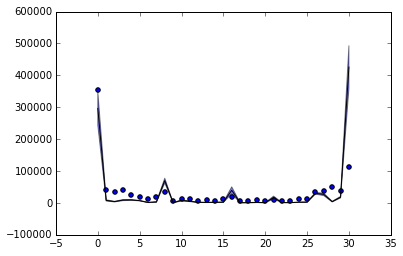

In [280]:
fig,ax=plt.subplots(1)
m=IS_DF_Grouped.mean()
sd=IS_DF_Grouped.std()
sd1=m+sd
sd2=m-sd

m=m.loc[EHX_SortedList_ForDF]
sd1=sd1.loc[EHX_SortedList_ForDF]
sd2=sd2.loc[EHX_SortedList_ForDF]
ax.fill_between(np.arange(31),sd1.TPM, sd2.TPM, facecolor='blue', alpha=0.5)

DF_E1_R=DF_E1.loc['E1-R'].loc[EHX_SortedList_ForDF]
DF_E2_R=DF_E2.loc['E2-R'].loc[EHX_SortedList_ForDF]

DF_E_R_Mean=(DF_E1_R.TPM+DF_E2_R.TPM)/2

ax.scatter(np.arange(31), DF_E_R_Mean)
ax.plot(m.TPM, 'k')
# ax.set_ylim(300000, 400000)
# ax.set_yscale('log')

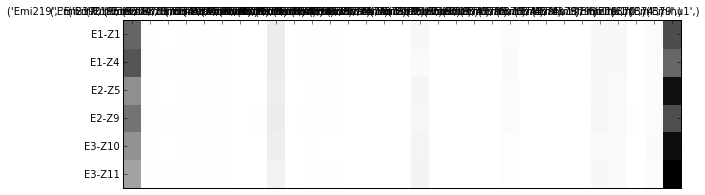

In [421]:
DF_IS_TPM=DF_IS.TPM.unstack()[EHX_SortedList_ForDF].sort()

def makeHeatMap(df, cmap='Greys', ax=True, logNorm=False):
    m, n = len(df.index), len(df.columns)
    if ax: 
        fig,ax=plt.subplots(1)
    fig.set_size_inches(n/3,m/2)
    vmin=df.min().min()
    vmax=df.max().max()
    if logNorm:
        ax.pcolor(df,  cmap=cmap,norm=LogNorm(vmin=vmin, vmax=vmax*1.25))
    else: 
        ax.pcolor(df,  cmap=cmap)
    ax.margins(0,0)
    ax.set_xticks(np.linspace(0.5, n-0.5, n))
    ax.set_xticklabels(df.columns)
    ax.set_yticks(np.linspace(0.5, m-0.5, m))
    ax.set_yticklabels(df.index)
    ax.grid('off')
    ax.xaxis.tick_top()

makeHeatMap(DF_IS_TPM.sort(ascending=False))


SyntaxError: invalid syntax (<ipython-input-382-3f69aa90f72c>, line 2)

In [306]:
DF_IS.swaplevel(0,1).loc["('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1')"].sort()

,TPM,Greater0,Len_total
E1-Z1,341150.75,2306,5243
E1-Z4,369177.55,2834,5243
E2-Z5,264497.36,2784,5243
E2-Z9,313564.34,3386,5243
E3-Z10,257840.06,2783,5243
E3-Z11,232694.59,2973,5243


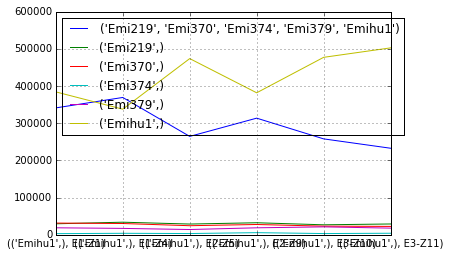

In [359]:
DF_CORE=DF_IS.swaplevel(0,1).sort()

ax=DF_CORE.loc[OfInterest].TPM.groupby(level=0).plot(legend=True,ax1=DF_CORE.index)


In [326]:
OfInterest=[EHX_SortedList_ForDF[0]]
OfInterest=OfInterest+EHX_SortedList_ForDF[-5:]
OfInterest

["('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1')",
 "('Emi219',)",
 "('Emi370',)",
 "('Emi374',)",
 "('Emi379',)",
 "('Emihu1',)"]

TPM  \
('Emi219', 'Emi370')                               E1-Z1    35778.36   
                                                   E1-Z4    23011.41   
                                                   E2-Z5    43485.30   
                                                   E2-Z9    33446.22   
                                                   E3-Z10   48769.77   
                                                   E3-Z11   52432.37   
('Emi219', 'Emi370', 'Emi374')                     E1-Z1     1250.25   
                                                   E1-Z4     1366.41   
                                                   E2-Z5     1102.57   
                                                   E2-Z9     2286.64   
                                                   E3-Z10    1182.40   
                                                   E3-Z11    1166.76   
('Emi219', 'Emi370', 'Emi374', 'Emi379')           E1-Z1     6562.11   
                                                   E1-Z4     9537.56   
                                                   E2-Z5     6814.59   
                                                   E2-Z9    10747.11   
                                                   E3-Z10    5982.57   
                                                   E3-Z11    7544.74   
('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1') E1-Z1   341150.75   
                                                   E1-Z4   369177.55   
                                                   E2-Z5   264497.36   
                                                   E2-Z9   313564.34   
                                                   E3-Z10  257840.06   
                                                   E3-Z11  232694.59   
('Emi219', 'Emi370', 'Emi374', 'Emihu1')           E1-Z1     3112.11   
                                                   E1-Z4     4561.37   
                                                   E2-Z5     3388.54   
                                                   E2-Z9     5600.72   
                                                   E3-Z10    3519.50   
                                                   E3-Z11    4347.44   
...                                                              ...   
('Emi374', 'Emihu1')                               E1-Z1     1659.13   
                                                   E1-Z4     2193.98   
                                                   E2-Z5     1826.52   
                                                   E2-Z9     2951.22   
                                                   E3-Z10    1622.20   
                                                   E3-Z11    2323.96   
('Emi374',)                                        E1-Z1     3126.39   
                                                   E1-Z4     4008.66   
                                                   E2-Z5     3367.89   
                                                   E2-Z9     5787.64   
                                                   E3-Z10    3340.04   
                                                   E3-Z11    4162.53   
('Emi379', 'Emihu1')                               E1-Z1     1489.86   
                                                   E1-Z4     2705.78   
                                                   E2-Z5     2088.73   
                                                   E2-Z9     3652.05   
                                                   E3-Z10    2015.84   
                                                   E3-Z11    2185.02   
('Emi379',)                                        E1-Z1    18849.85   
                                                   E1-Z4    17208.40   
                                                   E2-Z5    14195.89   
                                                   E2-Z9    18802.87   
                                                   E3-Z10   21327.00   
                                                   E3-Z11   17956.96   
('Emihu1',)                      